###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

dataset X.shape: (100, 2), X.dtype: float64, X.data:
[[ 1.03225485  0.30314179]
 [ 0.24031788 -0.02258841]
 [ 0.96250988  0.26911911]
 ...
 [ 0.0506929   0.43641413]
 [ 1.65040353 -0.33477239]
 [ 2.03736992  0.15660289]]
dataset y.shape: (100,), y.dtype: int64, y.data:
[0 1 0 ... 1 1 1]


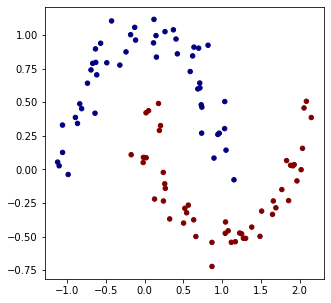

In [11]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

np.set_printoptions(threshold=50)
print(f'dataset X.shape: {X.shape}, X.dtype: {X.dtype}, X.data:\n{X}')
print(f'dataset y.shape: {y.shape}, y.dtype: {y.dtype}, y.data:\n{y}')

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model
model = MLP(nin=2, nouts=[16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of 3 Layers: [
  Layer[0]: Layer(in=2, out=16, activation=ReLU)
  Layer[1]: Layer(in=16, out=16, activation=ReLU)
  Layer[2]: Layer(in=16, out=1, activation=Linear)
]
number of parameters 337


In [8]:
# loss function

def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
        # print(f'ri: {ri}')
    # print(f'Xb shape: {Xb.shape}, dtype: {Xb.dtype}, data:\n{Xb}')
    # print(f'yb shape: {yb.shape}, dtype: {yb.dtype}, data:\n{yb}')

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(f'total_loss: {total_loss.data}, acc: {acc * 100}%')

total_loss: 0.8958441028683222, acc: 50.0%


In [9]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584198, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.31354548191852205, accuracy 86.0%
step 6 loss 0.2814234349772434, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.2704862551637922, accuracy 91.0%
step 10 loss 0.2450702385365805, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192296, accuracy 91.0%
step 13 loss 0.2309037844640272, accuracy 93.0%
step 14 loss 0.2015215122789945, accuracy 92.0%
step 15 loss 0.2257450627928222, accuracy 93.0%
step 16 loss 0.19447987596204114, accuracy 92.0%
step 17 loss 0.21089496199246355, accuracy 93.0%
step 18 loss 0.1598307735630361, accuracy 94.0%
step 19 loss 0.18453748746883916, accuracy 93.0%
step 20 loss 0.18977522856087645, accuracy 91

(-1.7222875713140986, 2.027712428685901)

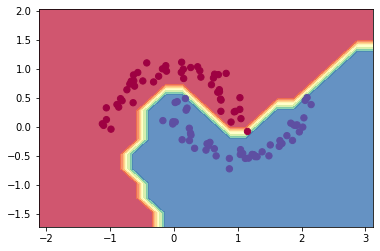

In [12]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
